In [55]:
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import matplotlib.pyplot as plt
from utilities import createAnnotation
from model_loader import get_new_model
import pandas as pd
from IPython.display import display
from PIL import Image 
import random
import numpy as np
import class_katalog

In [56]:
IMAGESROOTDIR = 'val'

In [57]:
class ImageDataset(Dataset):
    def __init__(self, rootDir):
        self.rootDir = rootDir
        createAnnotation(self.rootDir)
        self.annotation = pd.read_csv('output.csv')


    def __getitem__(self, index):
        data_path = self.annotation.iloc[index,0]
        image = Image.open(data_path)
        label = self.annotation.iloc[index,1]
        source = data_path
        return image, label, source

    def __len__(self):
        return len(self.annotation)

In [58]:
# instance of class ImageDataset
# contains all 765 images with their respective labels
imageDataset = ImageDataset(rootDir=IMAGESROOTDIR)

In [59]:
# Constants for the size of the images
SIZE = round(224/0.875)

# given an Index returns the transformed Image
# input: Index: int
# return: tuple(PIL Image, label)
def transform(index):
    assert index <= len(imageDataset)
    image, label, source = imageDataset[index]
    rescaledImage = fn.resize(img=image, size=[SIZE, SIZE], interpolation=T.InterpolationMode.BICUBIC)
    transformedImage = fn.center_crop(img=rescaledImage, output_size=[SIZE,SIZE])
    return transformedImage, label, source

In [60]:
# objects for tensor transformation
pilToTensor = T.ToTensor()
tensorToPil = T.ToPILImage()

In [61]:
# Class which is used to get the resized images with label
# input: datasetLength: int
# output:{'image': Tensor, 'label': String}
class DataLoader(Dataset):
    def __init__(self, datasetLength):
        self.datasetLength = datasetLength
   
    def __getitem__(self, index):
        self.index = index
        (picture, label, source) = transform(index)
        image = pilToTensor(picture)
        sample3dim = {'image' : image, 'label' : label}
        image = image.unsqueeze(0)
        sample = {'image': image, 'label': label}
        return sample, sample3dim, source

In [62]:
dataloader = DataLoader(len(imageDataset))
iterr = iter(dataloader)
im, lab, source = next(iterr)
print(im['image'].size())

torch.Size([1, 3, 256, 256])


In [63]:
# Amount of random samples 
BATCHSIZE = 4

dataloader = DataLoader(len(imageDataset))

'''
function creates a random batch of data with a given size
Arguments: batchsize:int
Return: an array with a dict[image:label] 
'''
def createRandomBatch(batchsize):
    #assert (0<batchsize <= len(imageDataset))
    batch = []
    batch3dim = []
    indexList = []
    sourceList = []
    for i in range(batchsize):
        index = random.randint(0,len(imageDataset))
        indexList.append(index)
        sample, sample3dim, source = dataloader[index]
        batch.append(sample)
        batch3dim.append(sample3dim)
        sourceList.append(source)
    return batch, batch3dim, indexList, sourceList

samples, samples3dim, indexList, sourceList = createRandomBatch(BATCHSIZE)
  
    
    

In [64]:
# loads pretrained model
model = get_new_model("convnext_tiny", not_original=True)
ckpt = torch.load('convnext_tiny_cvst_clean.pt', map_location='cpu') #['model']
                # print(ckpt.keys())
ckpt = {k.replace('module.', ''): v for k, v in ckpt.items()}
#ckpt = {k.replace('base_model.', ''): v for k, v in ckpt.items()}
#ckpt = {k.replace('se_', 'se_module.'): v for k, v in ckpt.items()}
#ckpt = {"".join(("model.", k)): v for k, v in ckpt.items()}

model.load_state_dict(ckpt)
print(model)

'''
function feeds the loaded model with data
Arguments: list[dict[image:tensor,label:str]]
Return: list[dict[image:tensor,label:str, prediction:tensor]]
'''
def feedModel(samples):
    assert(0<len(samples)<len(imageDataset))
    samplesWithPrediction =[]
    for sample in samples:
        image, label = sample['image'], sample['label']
        prediction = model(image)
        print(prediction.max(1)[1])
        sample['prediction'] = prediction
        samplesWithPrediction.append(sample)
    return samplesWithPrediction
        
samplesWithPrediction = feedModel(samples)
#print(samplesWithPrediction)

ConvNeXt(
  (stem): ConvBlock1(
    (stem): Sequential(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LayerNorm()
      (2): GELU(approximate='none')
      (3): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): LayerNorm()
      (5): GELU(approximate='none')
    )
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1)

tensor([198])
tensor([127])
tensor([572])
tensor([198])


['n02097209', 'n01855672', 'n03443371', 'n02097209']


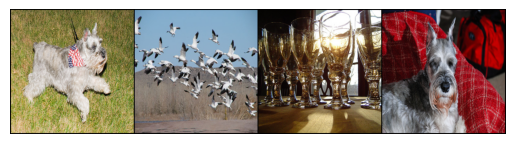

In [65]:
'''
function extracts the values from the samples dict
Arguments: dict which contains random batch dict
Return: returns the values from samples list
'''
def extractValuesFromDict(samples, key:str):
    values = []
    for dictionary in samples:
        values.append(dictionary[key])
        
    if key == 'label':
        print(values)
    return values


# function to visualize the batch
def visualize(samples):
    tensors = extractValuesFromDict(samples, 'image')
    grid_border_size = 2
    elementsPerRow = 4
    grid = torchvision.utils.make_grid(tensor=tensors, nrow=elementsPerRow, padding=grid_border_size)
    plt.imshow(grid.detach().numpy().transpose((1,2,0)))


plt.figure()
visualize(samples3dim)
extractValuesFromDict(samples3dim, 'label')
plt.axis('off')
plt.ioff()
plt.show()


In [66]:
# function that finds the top k predictions
def findMaxPredictions(samples, k:int):
    
    predictionsMax = []
    predictionsIndices = []
    
    for dictionary in samples:
        predictions = dictionary['prediction']
        tempPredictionsMax = []
        tempPredictionsIndices = []
        for i in range (0, k):
            maximums = []
            indices = []
            maximums = predictions.max().item()
            indices = predictions.argmax().item()
            tempPredictionsMax.append(maximums)
            tempPredictionsIndices.append(indices)
            predictions[0][indices] = - float('inf') # set probability of maximum to -inf to search for the next maximum
        predictionsMax.append(tempPredictionsMax)
        predictionsIndices.append(tempPredictionsIndices)
        
    return (predictionsMax, predictionsIndices)


# function that finds the labels to the top k predictions
def findLabels(samples, k:int):
    
    (predictionsMax, predictionsIndices) = findMaxPredictions(samples, k)
    allTopKLabels = []
    
    for i in range (0, len(samples)):
        topKLabels = []
        for j in range (0, k):
            topILabel = []
            topILabel = class_katalog.NAMES[predictionsIndices[i][j]]
            topKLabels.append(topILabel)
        allTopKLabels.append(topKLabels)
        
    return allTopKLabels

findLabels(samplesWithPrediction, 10)

[['standard schnauzer',
  'miniature schnauzer',
  'giant schnauzer',
  'Lhasa, Lhasa apso',
  'West Highland white terrier',
  'Dandie Dinmont, Dandie Dinmont terrier',
  'Irish terrier',
  'cocker spaniel, English cocker spaniel, cocker',
  'malinois',
  'hammer'],
 ['white stork, Ciconia ciconia',
  'goose',
  'oystercatcher, oyster catcher',
  'red-backed sandpiper, dunlin, Erolia alpina',
  'pelican',
  'ruddy turnstone, Arenaria interpres',
  'crane',
  'dowitcher',
  'bustard',
  'flamingo'],
 ['goblet',
  'beer glass',
  'wine bottle',
  'red wine',
  'cup',
  'water jug',
  'cocktail shaker',
  'restaurant, eating house, eating place, eatery',
  'candle, taper, wax light',
  'pitcher, ewer'],
 ['standard schnauzer',
  'Lhasa, Lhasa apso',
  'miniature schnauzer',
  'Australian terrier',
  'giant schnauzer',
  'Irish setter, red setter',
  'hatchet',
  'umbrella',
  'sleeping bag',
  'malinois']]